In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
sys.path.append('../experiments')
import seaborn as sns
import os
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
from os.path import join
import numpy as np
import imodelsx.process_results
from neuro.features import qa_questions, feature_spaces
from neuro.data import story_names
from neuro.features.stim_utils import load_story_wordseqs, load_story_wordseqs_huge
import random
import json
import joblib
from neuro.features.qa_questions import get_questions, get_merged_questions_v3_boostexamples
from tqdm import tqdm
from collections import defaultdict
fit_encoding = __import__('02_fit_encoding')

### Set up data for labeling

In [ ]:
story_names_list = ['wheretheressmoke']
print('loaded', len(story_names_list), 'stories')
# wordseqs = feature_spaces.get_story_wordseqs(story_names_train)
wordseqs = load_story_wordseqs_huge(story_names_list)

ngrams_list_total = []
for story in story_names_list:
    ngrams_list = feature_spaces.get_ngrams_list_main(
        wordseqs[story], num_ngrams_context=10)
    # print(ngrams_list[:10])
    ngrams_list_total.extend(ngrams_list)

# questions = np.array(get_merged_questions_v3_boostexamples())
questions = ['Does the sentence describe a personal reflection or thought?',
             'Does the sentence contain a proper noun?',
             'Does the sentence describe a physical action?',
             'Does the sentence describe a personal or social interaction that leads to a change or revelation?',
             'Does the sentence involve the mention of a specific object or item?',
             'Does the sentence involve a description of physical environment or setting?',
             'Does the sentence describe a relationship between people?',
             'Does the sentence mention a specific location?',
             'Is time mentioned in the input?',
             'Is the sentence abstract rather than concrete?',
             "Does the sentence express the narrator's opinion or judgment about an event or character?",
             'Is the input related to a specific industry or profession?',
             'Does the sentence include dialogue?',
             'Does the sentence describe a visual experience or scene?',
             'Does the input involve planning or organizing?',
             'Does the sentence involve spatial reasoning?',
             'Does the sentence involve an expression of personal values or beliefs?',
             'Does the sentence contain a negation?',
             'Does the sentence describe a sensory experience?',
             'Does the sentence include technical or specialized terminology?',
             'Does the input contain a number?',
             'Does the sentence contain a cultural reference?',
             'Does the text describe a mode of communication?',
             'Does the input include a comparison or metaphor?',
             'Does the sentence express a sense of belonging or connection to a place or community?',
             'Does the sentence describe a specific sensation or feeling?',
             'Does the text include a planning or decision-making process?',
             'Does the sentence include a personal anecdote or story?',
             'Does the sentence involve a discussion about personal or social values?',
             'Does the text describe a journey?',
             'Does the input contain a measurement?',
             'Does the sentence describe a physical sensation?',
             'Does the sentence include a direct speech quotation?',
             'Is the sentence reflective, involving self-analysis or introspection?',
             'Does the input describe a specific texture or sensation?']

In [ ]:
answers = np.full((len(ngrams_list_total), len(questions)), fill_value='')
df = pd.DataFrame(answers, columns=questions)
df['text'] = ngrams_list_total
# move question to first position
cols = list(df.columns)
cols = [cols[-1]] + cols[:-1]
df = df[cols]
df.to_csv('ngrams.csv')

In [ ]:
df

In [ ]:
df.to_csv('qs.csv')

In [ ]:
df

In [ ]:
from neuro.features.feature_spaces import get_gpt4_qa_embs_cached
embs_gpt4 = get_gpt4_qa_embs_cached(
    story_name=story_names_list[0], questions=questions, qa_questions_version=None)
embs_gpt4 = pd.DataFrame(embs_gpt4, columns=questions)

In [ ]:
embs_human1 = pd.read_csv(
    'qa_human1.csv')

In [38]:
assert embs_gpt4.shape[0] == embs_human1.shape[0]
accs_dict = defaultdict(list)
for i, q in enumerate(questions):
    notna = embs_human1[q].notna()
    accs_dict['acc'].append(
        np.mean(embs_gpt4[q][notna] == embs_human1[q][notna]))
    accs_dict['acc_baseline'].append(np.mean(embs_human1[q][notna]))

<Axes: >

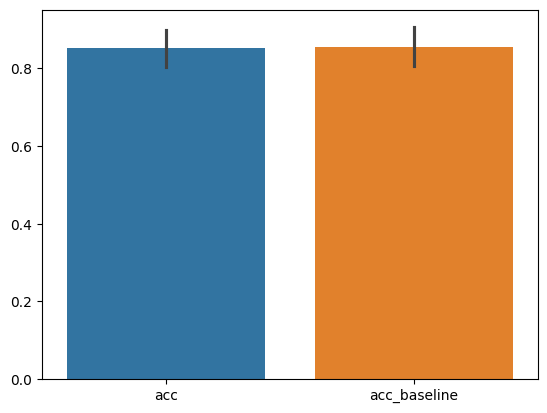

In [45]:
accs = pd.DataFrame(accs_dict)
accs['acc_baseline'] = accs['acc_baseline'].apply(lambda x: max(x, 1-x))

# seaborn plot distributions
# sns.swarmplot(data=accs, color='black')
sns.barplot(data=accs)

In [48]:
accs.style.background_gradient(cmap='coolwarm', axis=0)

,acc,acc_baseline
0,0.786070,0.522388
1,1.000000,1.000000
2,0.905473,0.601990
3,0.855721,1.000000
4,0.945274,0.646766
5,0.905473,0.880597
6,0.761194,0.865672
7,1.000000,1.000000
8,0.835821,1.000000
9,0.532338,0.905473


In [ ]:
notna